In [15]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [16]:
import os
import urllib
import shutil

def download_file(url, dir_path="data"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    file_name = os.path.split(url)[-1]
    file_path = os.path.join(dir_path, file_name)
    
    with urllib.request.urlopen(url) as response, open(file_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    return file_path

## Data matters more than algorithms

Зависимость точности различных алгоритмов от объема тренировочных данных (задача разрешения неоднозначности, [4]): 

<img src="data_vs_alg.png" width="500">

## Возможные проблемы с данными

1. Недостаточное количество данных (смотри выше)
2. Нерепрезентативные данные (выборы в США в 1936г., Landon vs. Roosevelt, опрос от Literary Digest)
3. Данные плохого качества
4. Нерелевантные фичи

## Анализ и визуализация данных

In [17]:
HOUSING_URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"
tgz_path = download_file(HOUSING_URL)

import tarfile
housing_tgz = tarfile.open(tgz_path)
housing_tgz.extractall(path="data/")
housing_tgz.close()

In [18]:
housing = pd.read_csv("data/housing.csv")
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [19]:
# Null значения
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [23]:
housing["total_bedrooms"].value_counts(dropna=False)

NaN        207
 280.0      55
 331.0      51
 345.0      50
 393.0      49
 343.0      49
 394.0      48
 328.0      48
 348.0      48
 272.0      47
 309.0      47
 295.0      46
 314.0      46
 322.0      46
 399.0      46
 317.0      46
 284.0      45
 388.0      45
 290.0      45
 291.0      45
 346.0      45
 287.0      45
 340.0      45
 313.0      45
 269.0      44
 460.0      44
 365.0      44
 294.0      44
 361.0      44
 312.0      44
          ... 
 2814.0      1
 6445.0      1
 2141.0      1
 2460.0      1
 3479.0      1
 1758.0      1
 1127.0      1
 2010.0      1
 1571.0      1
 3224.0      1
 1494.0      1
 1052.0      1
 2574.0      1
 1570.0      1
 1437.0      1
 2118.0      1
 3336.0      1
 2289.0      1
 1736.0      1
 940.0       1
 980.0       1
 1215.0      1
 2009.0      1
 3864.0      1
 1288.0      1
 1691.0      1
 2205.0      1
 1448.0      1
 1887.0      1
 2546.0      1
Name: total_bedrooms, Length: 1924, dtype: int64

In [22]:
# categorical значения
housing["ocean_proximity"].value_counts(dropna=False)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [25]:
# разные масштабы
housing.describe(percentiles=[0.1, 0.7, 0.9])

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
10%     -122.290000     33.630000           13.000000    941.000000   
50%     -118.490000     34.260000           29.000000   2127.000000   
70%     -118.130000     37.480000           36.000000   2876.000000   
90%     -117.250000     38.480000           46.000000   4651.500000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
10%        198.000000    510.000000    184.000000       1.903800   
50%        435.000000   1166.000000    409.000000       3.534800   
70%        591.000000   1580.000000    553.000000       4.437500   
90%        965.000000   2566.000000    890.000000       6.159210   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
10%          82300.000000  
50%         179700.000000  
70%         241930.000000  
90%         376600.000000  
max         500001.000000

In [26]:
# ограничения
_ = housing.hist(bins=50, figsize=(20,15))

## Training & test

На тестовые данные нельзя смотреть!!! Ну только мельком, чтобы убедиться, что они существуют и содержат что-то разумное. Наш мозг слишком хорош в вопросе идентификации паттернов и, изучив тестовые данные, мы можем создать модель, которая будет работать хорошо на этих данных, но плохо в целом (у этой проблемы даже есть название - data snooping bias). Поэтому, прежде чем начать работу над ML задачей, мы разбиваем данные на training и testing, а дальше, до момента тестирования, работаем только с training частью.

В стандартных случаях тренировочные данные должны быть сбалансированы. 

Например, если мы предсказываем значения 0/1, и мы предполагаем, что предсказываемые значения появляются в реальном мире с равной вероятностью, то у нас должно быть одинаковое количество нулей и единиц в тренировочных данных.

Другой пример: в США женщины составляют $51.3\%$ населения, а мужчины - $48.7\%$. Если мы хотим провести репрезентативный опрос среди 1000 респондентов, мы должны опросить 513 женщин и 487 мужчин. 

Такое разбиение называется stratified sampling, а группа в разбиении - strata (слой). При stratified sampling **не нужно** создавать много маленьких страт, иначе очень большие страты будут намного важнее очень маленьких, а мы хотим некоторого баланса.

In [30]:
# например, мы хотим подготовить median_income для stratified sampling (разбить на категории)
# если мы сделаем это в лоб, то получим и большие, и маленькие категории, что не очень хорошо
housing["median_income"].hist()

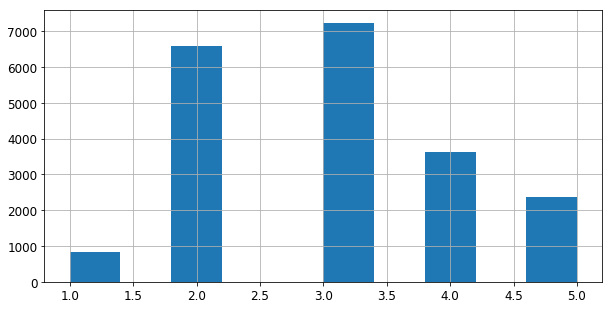

In [31]:
# трансформируем данные
# поделим на 1.5, чтобы уменьшить количество категорий
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# ограничим значения сверху
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

Модифицируя тренировочные данные, мы должны помнить, что потом нужно будет таким же образом изменить тестовые данные. Допустим, мы делим атрибут `median_income` на значение `tr_max_median_income=max(median_income)`, полученный из тренировочных данных. Тогда тестовые данные мы должны тоже поделить на `tr_max_median_income`, а не на `max(median_income)`, полученный из тестовых данных.

## Очистка данных

### Null значения

Большая часть алгоритмов машинного обучения не может работать с null значениями (т.е., мы должны очистить данные от них). Это можно сделать одним из трех способов:
1. Удалить атрибут (столбец), содержащий null значения (жестко)
2. Удалить строки, в которых атрибут равен null (может быть дорого)
3. Заменить null значения на какое-то другое значение (0, mean, median, most popular)

In [32]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
income_cat            20640 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB


In [35]:
# у total_bedrooms есть null значения, давайте заменим их на mean
# предварительно выкинем из рассмотрения ocean_proximity, так как это categorical атрибут и у него нет mean
from sklearn.preprocessing import Imputer
housing_num = housing.drop("ocean_proximity", axis=1)
imputer = Imputer(strategy="mean").fit(housing_num)
imputer.statistics_

array([-1.19569704e+02,  3.56318614e+01,  2.86394864e+01,  2.63576308e+03,
        5.37870553e+02,  1.42547674e+03,  4.99539680e+02,  3.87067100e+00,
        2.06855817e+05,  3.00668605e+00])

In [34]:
housing_num.mean().values

array([-1.19569704e+02,  3.56318614e+01,  2.86394864e+01,  2.63576308e+03,
        5.37870553e+02,  1.42547674e+03,  4.99539680e+02,  3.87067100e+00,
        2.06855817e+05,  3.00668605e+00])

In [40]:
_ = imputer.transform(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

### Категорийные атрибуты

Не все модели умеют работать с категорийными атрибутами. В зависимости от типа данных, такие атрибуты преобразуются либо в порядковые значения (если мы хотим сохранить зависимость), либо в бинарные фичи. 

Например, атрибут "расстояние" со значениями ["близко", "средне", "далеко"] можно преобразовать в тот же атрибут со значениями [0, 1, 2], либо в три новых атрибута "расстояние\_близко", "расстояние\_средне", "расстояние\_далеко" со значениями 1/0.

In [16]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([3, 3, 3, ..., 1, 1, 1])

In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
pd.get_dummies(housing["ocean_proximity"]).head()

<1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
0          0       0       0         1           0
1          0       0       0         1           0
2          0       0       0         1           0
3          0       0       0         1           0
4          0       0       0         1           0

## Масштабирование данных

За редким исключением (например, DecisionTrees), алгоритмы машинного обучения работают плохо, если у численных атрибутов разные масштабы (почему?). 

**Предсказываемые значения масштабировать не надо.**

Два основных способа масштабирования:
* min-max масштабирование (нормализация)
* стандартизация (отнять среднее, поделить на variance)

In [20]:
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler